# 1. Загрузка данных

In [1129]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [1130]:
# Настройка отображения графиков
%matplotlib inline

data_path = Path("data/cian_rentals.jsonl")

df = pd.read_json(data_path, lines=True)

print(f"Загружено записей: {len(df)}")

Загружено записей: 6371


In [1131]:
df.head()

,url,title,price_per_month,price_currency,cian_estimated_price,address,metro_count,metro_nearest_time,total_area,floor,facts,features,parsed_at
0,https://spb.cian.ru/rent/flat/325755125/?mlSea...,"Сдаются 2-комн. апартаменты, 35 м²",55000.0,RUB,NaN,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",2026-01-26 21:06:47.114500
1,https://spb.cian.ru/rent/flat/324842491/?mlSea...,"Сдаются 5-комн. апартаменты, 200 м²",200000.0,RUB,NaN,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],2026-01-26 21:06:50.615774
2,https://spb.cian.ru/rent/flat/326049379/?mlSea...,"Сдается студия, 15 м²",20500.0,RUB,NaN,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",2026-01-26 21:06:57.151698
3,https://spb.cian.ru/rent/flat/319887249/?mlSea...,"Сдается апартаменты-студия, 22 м²",33990.0,RUB,NaN,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",2026-01-26 21:07:01.557419
4,https://spb.cian.ru/rent/flat/325556962/?mlSea...,"Сдается апартаменты-студия, 14,1 м²",27000.0,RUB,NaN,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",2026-01-26 21:07:05.661957


In [1132]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   url                   6371 non-null   str           
 1   title                 6371 non-null   str           
 2   price_per_month       6158 non-null   float64       
 3   price_currency        6371 non-null   str           
 4   cian_estimated_price  0 non-null      float64       
 5   address               6371 non-null   str           
 6   metro_count           6371 non-null   int64         
 7   metro_nearest_time    6371 non-null   str           
 8   total_area            6371 non-null   str           
 9   floor                 6371 non-null   str           
 10  facts                 6371 non-null   object        
 11  features              6371 non-null   object        
 12  parsed_at             6371 non-null   datetime64[us]
dtypes: datetime64[us](1), float64

# 2. Очистка данных
### 2.1. Априори ненужные или null-поля

In [1133]:
df.drop(columns=["url", "cian_estimated_price", "parsed_at"], inplace=True)
df.head()

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
0,"Сдаются 2-комн. апартаменты, 35 м²",55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,"Сдаются 5-комн. апартаменты, 200 м²",200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,"Сдается студия, 15 м²",20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,"Сдается апартаменты-студия, 22 м²",33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,"Сдается апартаменты-студия, 14,1 м²",27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


## 2.2. Записи, которые не были спаршены из-за антибот проверок

In [1134]:
df[df["title"].str.contains("VPN")]

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
6018,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6020,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6021,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6023,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6024,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
...,...,...,...,...,...,...,...,...,...,...
6364,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6366,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6367,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]
6369,"Кажется, у вас включён VPN",NaN,RUB,,0,,,,{},[]


In [1135]:
df = df[~df["title"].str.contains("VPN")]
df[df["title"].str.contains("VPN")]

,title,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features


In [1136]:
df = df.drop(columns=["title"])

## 2.3. Null записи

In [1137]:
df.info()

<class 'pandas.DataFrame'>
Index: 6159 entries, 0 to 6368
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_per_month     6158 non-null   float64
 1   price_currency      6159 non-null   str    
 2   address             6159 non-null   str    
 3   metro_count         6159 non-null   int64  
 4   metro_nearest_time  6159 non-null   str    
 5   total_area          6159 non-null   str    
 6   floor               6159 non-null   str    
 7   facts               6159 non-null   object 
 8   features            6159 non-null   object 
dtypes: float64(1), int64(1), object(2), str(5)
memory usage: 481.2+ KB


In [1138]:
df[df["price_per_month"].isna()]

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
4993,NaN,RUB,,0,,,,{},[]


In [1139]:
df.dropna(inplace=True)
df.info()

<class 'pandas.DataFrame'>
Index: 6158 entries, 0 to 6368
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_per_month     6158 non-null   float64
 1   price_currency      6158 non-null   str    
 2   address             6158 non-null   str    
 3   metro_count         6158 non-null   int64  
 4   metro_nearest_time  6158 non-null   str    
 5   total_area          6158 non-null   str    
 6   floor               6158 non-null   str    
 7   facts               6158 non-null   object 
 8   features            6158 non-null   object 
dtypes: float64(1), int64(1), object(2), str(5)
memory usage: 481.1+ KB


In [1140]:
df.head()

,price_per_month,price_currency,address,metro_count,metro_nearest_time,total_area,floor,facts,features
0,55000.0,RUB,"Санкт-Петербург, р-н Московский, Гагаринское, ...",3,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,200000.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",3,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,20500.0,RUB,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",3,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,33990.0,RUB,"Санкт-Петербург, р-н Выборгский, Светлановское...",3,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,27000.0,RUB,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",3,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


## 2.4. Анализ отдельных полей на их необходимость
### 2.4.1. Простые проверки на логичность данных

In [1141]:
df["price_currency"].unique().tolist()

['RUB']

т.е. всего 1 валюта => колонка **price_currency** бесполезна

In [1142]:
df["metro_count"].value_counts()

metro_count
3    6155
1       2
0       1
Name: count, dtype: int64

т.е. всего 3 значения, отличных от абсолютного большинства (меньше 1%) => колонка **metro_count** бесполезна

In [1143]:
np.modf(df["price_per_month"])[0].unique()

array([0.])

т.е. содержит только целочисленные значения => колонка **price_per_month** м.б. приведена к целому

In [1144]:
df = df.drop(columns=["price_currency", "metro_count"])
df["price_per_month"] = df["price_per_month"].astype(int)

In [1145]:
df.head()

,price_per_month,address,metro_nearest_time,total_area,floor,facts,features
0,55000,"Санкт-Петербург, р-н Московский, Гагаринское, ...",1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,200000,"Санкт-Петербург, р-н Адмиралтейский, Адмиралте...",19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,20500,"Санкт-Петербург, р-н Адмиралтейский, Коломна, ...",4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,33990,"Санкт-Петербург, р-н Выборгский, Светлановское...",11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,27000,"Санкт-Петербург, р-н Центральный, Лиговка-Ямск...",7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


### 2.4.2. Районы, кварталы...

In [1146]:
df["address"].str.contains("Санкт-Петербург")

0       True
1       True
2       True
3       True
4       True
        ... 
6358    True
6359    True
6361    True
6365    True
6368    True
Name: address, Length: 6158, dtype: bool

In [1147]:
df["address"] = df["address"].str.replace("Санкт-Петербург, ", "")
df.head()

,price_per_month,address,metro_nearest_time,total_area,floor,facts,features
0,55000,"р-н Московский, Гагаринское, Витебский просп.,...",1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная..."
1,200000,"р-н Адмиралтейский, Адмиралтейский, наб. Реки ...",19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[]
2,20500,"р-н Адмиралтейский, Коломна, Витебская ул., 5/6",4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин..."
3,33990,"р-н Выборгский, Светлановское, Политехническая...",11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная..."
4,27000,"р-н Центральный, Лиговка-Ямская, Лиговский про...",7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин..."


In [1148]:
df["city_district"] = df["address"].str.split(", ").str[0].str.replace("р-н ", "")
df = df.drop(columns=["address"])

df.head()

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный


In [1149]:
df["city_district"].value_counts()

city_district
Центральный          1118
Адмиралтейский        928
Выборгский            844
Московский            745
Приморский            685
Фрунзенский           575
Василеостровский      364
Красногвардейский     359
Невский               249
Калининский           228
Красносельский         32
Петроградский          13
Пушкинский             10
Кировский               4
Курортный               2
Кронштадтский           1
Херсонский проезд       1
Name: count, dtype: int64

In [1150]:
counts = df["city_district"].value_counts()
rare_districts = counts[counts < 50].index

df["city_district"] = df["city_district"].replace(rare_districts, "Другой")

# "Херсонский проезд" - это явная ошибка парсинга, так как это адрес в центре
df["city_district"] = df["city_district"].replace("Херсонский проезд", "Центральный")

df["city_district"].value_counts()

city_district
Центральный          1118
Адмиралтейский        928
Выборгский            844
Московский            745
Приморский            685
Фрунзенский           575
Василеостровский      364
Красногвардейский     359
Невский               249
Калининский           228
Другой                 63
Name: count, dtype: int64

### 2.4.3. Время до метро

In [1151]:
df[~df["metro_nearest_time"].str.contains("мин")]

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
3708,40000,,55 м²,3 из 3,"{'Оплата ЖКХ': '5 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Другой


осталась странная запись с пустым, но в то же время не-null metro_nearest_time. убираем ее

In [1152]:
df = df[df["metro_nearest_time"].str.contains("мин")]

проверяем еще раз

In [1153]:
df[df["metro_nearest_time"].str.contains("мин")]

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1 мин,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19 мин,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4 мин,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11 мин,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7 мин,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный
...,...,...,...,...,...,...,...
6358,34700,14 мин,25 м²,13 из 20,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Выборгский
6359,36700,13 мин,25 м²,7 из 14,"{'Оплата ЖКХ': '6 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Красногвардейский
6361,65000,11 мин,"30,5 м²",11 из 25,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Приморский
6365,114300,3 мин,"38,1 м²",5 из 7,"{'Оплата ЖКХ': 'не включена', 'Залог': '228 60...","[Холодильник, Кондиционер, Телевизор, Интернет...",Центральный


т.е. все значения в минутах => колонка **metro_nearest_time** м.б. приведена к целочисленному типу

In [1154]:
df["metro_nearest_time"] = df["metro_nearest_time"].str.replace(" мин", "").astype(int)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный


### 2.4.4. Жил-площадь

In [1155]:
df[df["total_area"].str.contains("м²")]

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1,35 м²,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19,200 м²,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4,15 м²,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11,22 м²,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7,"14,1 м²",1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный
...,...,...,...,...,...,...,...
6358,34700,14,25 м²,13 из 20,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Выборгский
6359,36700,13,25 м²,7 из 14,"{'Оплата ЖКХ': '6 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Красногвардейский
6361,65000,11,"30,5 м²",11 из 25,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Приморский
6365,114300,3,"38,1 м²",5 из 7,"{'Оплата ЖКХ': 'не включена', 'Залог': '228 60...","[Холодильник, Кондиционер, Телевизор, Интернет...",Центральный


т.е. все значения в квадратных метах => колонка **total_area** м.б. приведена к вещественному типу

In [1156]:
df["total_area"] = df["total_area"].str.replace(" м²", "").str.replace("\xa0м²", "").str.replace(",", ".").astype(float)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1,35.0,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19,200.0,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4,15.0,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11,22.0,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7,14.1,1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный


### 2.4.5. Этажи

In [1157]:
df[df["floor"].str.contains("из")]

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1,35.0,11 из 21,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19,200.0,4 из 5,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4,15.0,1 из 4,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11,22.0,8 из 11,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7,14.1,1 из 2,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный
...,...,...,...,...,...,...,...
6358,34700,14,25.0,13 из 20,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Выборгский
6359,36700,13,25.0,7 из 14,"{'Оплата ЖКХ': '6 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Красногвардейский
6361,65000,11,30.5,11 из 25,"{'Оплата ЖКХ': '4 000 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Приморский
6365,114300,3,38.1,5 из 7,"{'Оплата ЖКХ': 'не включена', 'Залог': '228 60...","[Холодильник, Кондиционер, Телевизор, Интернет...",Центральный


т.е. все значения содержат этаж x из y => колонка **floor** м.б. трансформирована в дробную запись в диапазоне [0; 1]

In [1158]:
df["floor"] = df["floor"].str.split(" из ").apply(lambda x: float(x[0]) / float(x[1])).round(2)
df.head()

,price_per_month,metro_nearest_time,total_area,floor,facts,features,city_district
0,55000,1,35.0,0.52,"{'Оплата ЖКХ': '10 000 ₽ (счётчики включены)',...","[Холодильник, Посудомоечная машина, Стиральная...",Московский
1,200000,19,200.0,0.80,"{'Оплата ЖКХ': 'включена (без счётчиков)', 'За...",[],Адмиралтейский
2,20500,4,15.0,0.25,"{'Оплата ЖКХ': '5 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Стиральная машина, Телевизор, Ин...",Адмиралтейский
3,33990,11,22.0,0.73,"{'Оплата ЖКХ': '3 500 ₽ (без счётчиков)', 'Зал...","[Холодильник, Посудомоечная машина, Стиральная...",Выборгский
4,27000,7,14.1,0.50,"{'Оплата ЖКХ': '6 000 ₽ (счётчики включены)', ...","[Холодильник, Стиральная машина, Телевизор, Ин...",Центральный


### 2.4.6. Фичи!
#### 2.4.6.1. Общий анализ

In [1159]:
facts_df = pd.json_normalize(df["facts"])
facts_df

,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Тип жилья,Планировка,Санузел,Вид из окон,Ремонт,Количество лифтов,Тип дома,Парковка,Предоплаты,Высота потолков,Год постройки,Строительная серия,Тип перекрытий,Подъезды,Отопление,Аварийность,Газоснабжение,Комиссии,Балкон/лоджия,О подъезде,Спальных мест,Придомовая территория,Торг
0,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,35 м²,20 м²,10 м²,11 из 21,Апартаменты,Смежная/Изолированная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,200 м²,NaN,"22,7 м²",4 из 5,Апартаменты,NaN,NaN,На улицу и двор,Евроремонт,NaN,Панельный,NaN,нет,3 м,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,15 м²,NaN,NaN,1 из 4,NaN,Смежная,1 совмещенный,NaN,Косметический,NaN,Кирпичный,NaN,NaN,NaN,1798,Индивидуальный проект,Смешанные,3,Центральное,Нет,Центральное,NaN,NaN,NaN,NaN,NaN,NaN
3,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,22 м²,NaN,NaN,8 из 11,Апартаменты,Смежная,1 совмещенный,На улицу и двор,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,NaN,NaN,2019,NaN,Нет информации,NaN,Нет информации,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN
4,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,"14,1 м²","11,1 м²",3 м²,1 из 2,Апартаменты,Смежная,1 совмещенный,Во двор,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,4 000 ₽ (без счётчиков),18 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,25 м²,NaN,NaN,13 из 20,NaN,NaN,1 совмещенный,NaN,Евроремонт,"4 пассажирских, 1 грузовой",Монолитный,Наземная,NaN,NaN,2022,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN
6359,6 000 ₽ (без счётчиков),18 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,25 м²,NaN,NaN,7 из 14,Апартаменты,NaN,1 совмещенный,NaN,Евроремонт,"2 пассажирских, 2 грузовых",NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,NaN,NaN
6361,4 000 ₽ (без счётчиков),65 000 ₽,NaN,2 месяца,от года,NaN,"30,5 м²",10 м²,5 м²,11 из 25,NaN,Изолированная,1 раздельный,NaN,Дизайнерский,4 грузовых,Монолитно-кирпичный,Наземная,NaN,"2,8 м",2015,Индивидуальный проект,Железобетонные,1,Центральное,Нет,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN
6365,не включена,228 600 ₽,NaN,1 месяц,от года,NaN,"38,1 м²",NaN,7 м²,5 из 7,Апартаменты,Изолированная,1 совмещенный,NaN,Дизайнерский,1 пассажирский,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет,1 лоджия,NaN,NaN,NaN,NaN


In [1160]:
facts_df.info()

<class 'pandas.DataFrame'>
Index: 6157 entries, 0 to 6368
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Оплата ЖКХ             6157 non-null   str  
 1   Залог                  6157 non-null   str  
 2   Комиссия               2082 non-null   str  
 3   Предоплата             5361 non-null   str  
 4   Срок аренды            6157 non-null   str  
 5   Условия проживания     4702 non-null   str  
 6   Общая площадь          6157 non-null   str  
 7   Жилая площадь          2940 non-null   str  
 8   Площадь кухни          3004 non-null   str  
 9   Этаж                   6157 non-null   str  
 10  Тип жилья              3684 non-null   str  
 11  Планировка             2498 non-null   str  
 12  Санузел                5160 non-null   str  
 13  Вид из окон            1871 non-null   str  
 14  Ремонт                 5593 non-null   str  
 15  Количество лифтов      4477 non-null   str  
 16  Тип 

сразу удаляем колонки, данные о которых уже знаем

In [1161]:
facts_df = facts_df.drop(columns=["Общая площадь", "Этаж"])

также удалим сразу те колонки, данных о которых очень мало

In [1162]:
facts_df = facts_df.drop(
    columns=[
        "Жилая площадь",
        "Площадь кухни",
        "Планировка",
        "Вид из окон",
        "Предоплаты",
        "Строительная серия",
        "Высота потолков",
        "Подъезды",
        "Аварийность",
        "Газоснабжение",
        "Комиссии",
        "Спальных мест",
        "Придомовая территория",
    ]
)

In [1163]:
facts_df.info()

<class 'pandas.DataFrame'>
Index: 6157 entries, 0 to 6368
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Оплата ЖКХ          6157 non-null   str  
 1   Залог               6157 non-null   str  
 2   Комиссия            2082 non-null   str  
 3   Предоплата          5361 non-null   str  
 4   Срок аренды         6157 non-null   str  
 5   Условия проживания  4702 non-null   str  
 6   Тип жилья           3684 non-null   str  
 7   Санузел             5160 non-null   str  
 8   Ремонт              5593 non-null   str  
 9   Количество лифтов   4477 non-null   str  
 10  Тип дома            4007 non-null   str  
 11  Парковка            4653 non-null   str  
 12  Год постройки       4178 non-null   str  
 13  Тип перекрытий      3002 non-null   str  
 14  Отопление           3002 non-null   str  
 15  Балкон/лоджия       1922 non-null   str  
 16  О подъезде          326 non-null    str  
 17  Торг       

In [1164]:
pd.set_option("display.max_columns", None)

facts_df

,Оплата ЖКХ,Залог,Комиссия,Предоплата,Срок аренды,Условия проживания,Тип жилья,Санузел,Ремонт,Количество лифтов,Тип дома,Парковка,Год постройки,Тип перекрытий,Отопление,Балкон/лоджия,О подъезде,Торг
0,10 000 ₽ (счётчики включены),27 500 ₽,50%,1 месяц,от года,можно с детьми и животными,Апартаменты,1 совмещенный,Евроремонт,"2 пассажирских, 1 грузовой",Монолитно-кирпичный,Подземная,NaN,NaN,NaN,NaN,NaN,NaN
1,включена (без счётчиков),200 000 ₽,50%,NaN,от года,NaN,Апартаменты,NaN,Евроремонт,NaN,Панельный,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5 500 ₽ (без счётчиков),20 500 ₽,100%,1 месяц,от года,можно с животными,NaN,1 совмещенный,Косметический,NaN,Кирпичный,NaN,1798,Смешанные,Центральное,NaN,NaN,NaN
3,3 500 ₽ (без счётчиков),34 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,Апартаменты,1 совмещенный,Евроремонт,"2 пассажирских, 2 грузовых",Монолитный,Подземная,2019,Нет информации,Нет информации,1 лоджия,NaN,NaN
4,6 000 ₽ (счётчики включены),30 000 ₽,NaN,1 месяц,от года,можно с детьми и животными,Апартаменты,1 совмещенный,Косметический,NaN,NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,4 000 ₽ (без счётчиков),18 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,NaN,1 совмещенный,Евроремонт,"4 пассажирских, 1 грузовой",Монолитный,Наземная,2022,NaN,NaN,NaN,NaN,NaN
6359,6 000 ₽ (без счётчиков),18 000 ₽,NaN,1 месяц,несколько месяцев,можно с детьми и животными,Апартаменты,1 совмещенный,Евроремонт,"2 пассажирских, 2 грузовых",NaN,Наземная,NaN,NaN,NaN,NaN,NaN,NaN
6361,4 000 ₽ (без счётчиков),65 000 ₽,NaN,2 месяца,от года,NaN,NaN,1 раздельный,Дизайнерский,4 грузовых,Монолитно-кирпичный,Наземная,2015,Железобетонные,Центральное,1 лоджия,NaN,NaN
6365,не включена,228 600 ₽,NaN,1 месяц,от года,NaN,Апартаменты,1 совмещенный,Дизайнерский,1 пассажирский,NaN,NaN,NaN,NaN,NaN,1 лоджия,NaN,NaN


#### 2.4.6.2. Анализ отдельных фич
##### 2.4.6.2.1. Оплата ЖКХ

In [1165]:
facts_df["Оплата ЖКХ"].value_counts()

Оплата ЖКХ
5 000 ₽ (без счётчиков)         1104
не включена                     1066
4 000 ₽ (без счётчиков)          450
6 000 ₽ (без счётчиков)          443
6 000 ₽ (счётчики включены)      435
7 000 ₽ (без счётчиков)          317
6 500 ₽ (без счётчиков)          263
включена (без счётчиков)         238
5 000 ₽ (счётчики включены)      226
5 500 ₽ (без счётчиков)          222
8 000 ₽ (без счётчиков)          221
10 000 ₽ (счётчики включены)     209
9 000 ₽ (без счётчиков)          208
4 500 ₽ (без счётчиков)          197
10 000 ₽ (без счётчиков)         195
3 500 ₽ (без счётчиков)          123
2 500 ₽ (без счётчиков)           79
4 000 ₽ (счётчики включены)       70
3 000 ₽ (без счётчиков)           37
5 500 ₽ (счётчики включены)       22
2 000 ₽ (без счётчиков)            4
15 000 ₽ (без счётчиков)           3
4 900 ₽ (без счётчиков)            3
3 000 ₽ (счётчики включены)        3
20 000 ₽ (без счётчиков)           3
17 000 ₽ (без счётчиков)           2
3 800 ₽ (без счётчиков)    

Оплата ЖКХ:
1. включена (без счетчиков) - входит в стоимость аренды, плата переменная (=услуги=0, ~счетчики)
2. не включена - полностью зависит от использования услуг арендатором, плата переменная (~услуги, ~счетчики)
3. x рублей (без счетчиков) - x рублей, сверху только счетчики, плата переменная (=услуги, ~счетчики)
4. x рублей (счетчики включены) - x рублей, плата фиксированная (=услуги, =счетчики=0)

Для потенциальной модели можно разложить в следующие столбцы:
1. `utility_fixed_bill [int]`: Фиксированная сумма оплаты из строки. Если плата "не включена" => ставим 0
2. `utility_usage_bill_flg [bool]`: 1, если вся квитанция платится арендатором за фактическое потребление ("не включена")
3. `utility_counters_extra_flg [bool]`: 1, если счетчики оплачиваются сверху (варианты "без счётчиков" и "не включена")

In [1166]:
facts_df["utility_fixed_bill"] = (
    facts_df["Оплата ЖКХ"].str.extract(r"(\d+ \d+)")[0].str.replace(" ", "").fillna("0").astype(int)
)
facts_df["utility_usage_bill_flg"] = facts_df["Оплата ЖКХ"].str.contains("не включена").astype(int)
facts_df["utility_counters_extra_flg"] = (
    facts_df["Оплата ЖКХ"].apply(lambda x: "не включена" in x or "без счётчиков" in x).astype(int)
)

facts_df = facts_df.drop(columns=["Оплата ЖКХ"])

##### 2.4.6.2.2. Залог

In [1167]:
facts_df["Залог"].value_counts()

Залог
20 000 ₽     640
18 000 ₽     627
30 000 ₽     514
35 000 ₽     352
25 000 ₽     333
50 000 ₽     321
20 500 ₽     220
48 000 ₽     211
47 000 ₽     211
27 500 ₽     209
200 000 ₽    209
44 000 ₽     208
75 000 ₽     208
45 000 ₽     207
33 000 ₽     206
228 600 ₽    205
10 000 ₽     199
60 000 ₽     184
727 760 ₽    171
37 000 ₽     142
85 000 ₽     138
34 000 ₽     108
26 000 ₽      70
нет           51
65 000 ₽      39
32 000 ₽      27
29 500 ₽      22
40 000 ₽      13
38 000 ₽      11
55 000 ₽       9
29 000 ₽       9
15 000 ₽       8
80 000 ₽       7
70 000 ₽       7
120 000 ₽      7
24 000 ₽       5
100 000 ₽      5
21 000 ₽       5
27 000 ₽       4
150 000 ₽      3
280 000 ₽      3
95 000 ₽       3
53 000 ₽       3
430 000 ₽      3
170 000 ₽      2
220 000 ₽      2
130 000 ₽      2
56 000 ₽       2
59 000 ₽       2
64 000 ₽       2
38 500 ₽       1
190 000 ₽      1
67 000 ₽       1
79 000 ₽       1
42 000 ₽       1
39 000 ₽       1
58 000 ₽       1
43 000 ₽       1
Name: co

In [1168]:
facts_df["deposit"] = facts_df["Залог"].apply(
    lambda x: 0 if "нет" in x else int(re.findall(r"(\d+ \d+)", x)[0].replace(" ", ""))
)
facts_df = facts_df.drop(columns=["Залог"])

##### 2.4.6.2.3. Комиссия

In [1169]:
facts_df["Комиссия"].value_counts()

Комиссия
50%     1286
100%     643
45%       70
70%       33
60%       22
80%       20
73%        3
90%        2
79%        1
65%        1
30%        1
Name: count, dtype: int64

In [1170]:
facts_df["comission"] = facts_df["Комиссия"].str.replace("%", "").fillna("0").astype(float) / 100
facts_df = facts_df.drop(columns=["Комиссия"])

2.4.6.2.4. Предоплата

In [1171]:
facts_df["Предоплата"].value_counts()

Предоплата
1 месяц     5320
2 месяца      41
Name: count, dtype: int64

In [1172]:
facts_df["prepayment_months_cnt"] = facts_df["Предоплата"].str.replace(r"[^\d]", "", regex=True).fillna("0").astype(int)
facts_df = facts_df.drop(columns=["Предоплата"])

##### 2.4.6.2.4. Срок аренды

In [1173]:
facts_df["Срок аренды"].value_counts()

Срок аренды
от года              3313
несколько месяцев    2844
Name: count, dtype: int64

In [1174]:
facts_df["rent_term_months"] = (
    facts_df["Срок аренды"].fillna("помесячно").map({"от года": 12, "несколько месяцев": 3, "помесячно": 1}).astype(int)
)
facts_df = facts_df.drop(columns=["Срок аренды"])

##### 2.4.6.2.5. Условия проживания

In [1175]:
facts_df["Условия проживания"].value_counts()

Условия проживания
можно с детьми и животными    2500
можно с детьми                1569
можно с животными              633
Name: count, dtype: int64

будет лучше удалить этот столбец т.к. непонятно, что делать с теми данными, в которых условий проживания не прописано

In [1176]:
facts_df = facts_df.drop(columns=["Условия проживания"])

##### 2.4.6.2.6. Тип жилья

In [1177]:
facts_df["Тип жилья"].value_counts()

Тип жилья
Апартаменты    3684
Name: count, dtype: int64

In [1178]:
facts_df["apartments_flg"] = facts_df["Тип жилья"].str.contains("Апартаменты").astype(int)
facts_df = facts_df.drop(columns=["Тип жилья"])

##### 2.4.6.2.7. Санузел

In [1179]:
facts_df["Санузел"].value_counts()

Санузел
1 совмещенный                  4201
1 раздельный                    944
2 совмещенных                     7
1 совмещенный, 1 раздельный       6
2 совмещенных, 1 раздельный       1
2 раздельных                      1
Name: count, dtype: int64

In [1180]:
facts_df["combined_bathrooms_cnt"] = facts_df["Санузел"].str.extract(r"(\d+)\s+совмещ")[0].fillna(0).astype(int)
facts_df["separate_bathrooms_cnt"] = facts_df["Санузел"].str.extract(r"(\d+)\s+раздел")[0].fillna(0).astype(int)
facts_df = facts_df.drop(columns=["Санузел"])

##### 2.4.6.2.8. Ремонт

In [1181]:
facts_df["Ремонт"].value_counts()

Ремонт
Евроремонт       2444
Косметический    1600
Дизайнерский     1549
Name: count, dtype: int64

вероятнее всего, если информации о ремонте не указано, значит его нет! значит тут можно просто выполнить маппинг

In [1182]:
facts_df["repair_level"] = (
    facts_df["Ремонт"]
    .fillna("Без ремонта")
    .map({"Без ремонта": 0, "Косметический": 1, "Евроремонт": 2, "Дизайнерский": 3})
)
facts_df = facts_df.drop(columns=["Ремонт"])

##### 2.4.6.2.9. Количество лифтов

In [1183]:
facts_df["Количество лифтов"].value_counts()

Количество лифтов
1 пассажирский, 1 грузовой    1141
2 пассажирских, 1 грузовой    1120
2 пассажирских, 2 грузовых     626
1 пассажирский                 552
4 пассажирских, 1 грузовой     335
2 пассажирских                 228
3 пассажирских                 218
4 пассажирских, 2 грузовых     198
4 грузовых                      39
1 грузовой                       6
3 пассажирских, 1 грузовой       4
1 пассажирский, 2 грузовых       3
4 пассажирских, 4 грузовых       2
3 пассажирских, 2 грузовых       2
3 пассажирских, 3 грузовых       2
2 грузовых                       1
Name: count, dtype: int64

In [1184]:
facts_df["freight_elevators_cnt"] = facts_df["Количество лифтов"].str.extract(r"(\d+)\s+груз")[0].fillna(0).astype(int)
facts_df["passenger_elevators_cnt"] = facts_df["Количество лифтов"].str.extract(r"(\d+)\s+пас")[0].fillna(0).astype(int)
facts_df = facts_df.drop(columns=["Количество лифтов"])

##### 2.4.6.2.10. Парковка

In [1185]:
facts_df["Парковка"].value_counts()

Парковка
Наземная          3460
Подземная         1132
Открытая            53
Многоуровневая       8
Name: count, dtype: int64

In [1186]:
facts_df["parking_level"] = (
    facts_df["Парковка"].map({"Подземная": 2, "Многоуровневая": 2, "Наземная": 1, "Открытая": 1}).fillna(0).astype(int)
)

facts_df = facts_df.drop(columns=["Парковка"])

##### 2.4.6.2.11. Отопление

In [1187]:
facts_df["Отопление"].value_counts()

Отопление
Центральное                      1862
Нет информации                    784
Индивидуальный тепловой пункт     345
Автономная котельная                8
Котел/Квартирное отопление          3
Name: count, dtype: int64

In [1188]:
(
    facts_df["Отопление"]
    .map(
        {
            "Котел/Квартирное отопление": 3,
            "Индивидуальный тепловой пункт": 3,
            "Автономная котельная": 2,
            "Центральное": 1,
            "Нет информации": 0,
        }
    )
    .fillna(0)
    .astype(int)
    .value_counts()
)

Отопление
0    3939
1    1862
3     348
2       8
Name: count, dtype: int64

очень много пустых данных. дучше удалить этот столбец

In [1189]:
facts_df = facts_df.drop(columns=["Отопление"])

##### 2.4.6.2.12. Балконы

In [1190]:
facts_df["Балкон/лоджия"].value_counts()

Балкон/лоджия
1 лоджия              1253
1 балкон               663
1 лоджия, 1 балкон       2
2 лоджии                 2
3 лоджии                 1
2 балкона                1
Name: count, dtype: int64

In [1191]:
facts_df["balcony_cnt"] = facts_df["Балкон/лоджия"].str.extract(r"(\d+)\s+балк")[0].fillna(0).astype(int)
facts_df["loggia_cnt"] = facts_df["Балкон/лоджия"].str.extract(r"(\d+)\s+лодж")[0].fillna(0).astype(int)
facts_df = facts_df.drop(columns=["Балкон/лоджия"])

##### 2.4.6.2.13. Тип подъезда

In [1192]:
facts_df["О\xa0подъезде"].value_counts()

О подъезде
Есть мусоропровод              318
Есть консьерж                    5
Есть мусоропровод, консьерж      3
Name: count, dtype: int64

In [1193]:
facts_df["has_garbage_chute_flg"] = facts_df["О\xa0подъезде"].str.contains("мусоропровод", na=False).astype(int)
facts_df["has_concierge_flg"] = facts_df["О\xa0подъезде"].str.contains("консьерж", na=False).astype(int)
facts_df = facts_df.drop(columns=["О\xa0подъезде"])

##### 2.4.6.2.14. Торг

In [1194]:
facts_df["Торг"].value_counts()

Торг
возможен    12
Name: count, dtype: int64

будет лучше удалить это поле

In [1195]:
facts_df = facts_df.drop(columns=["Торг"])

In [1196]:
facts_df.info()

<class 'pandas.DataFrame'>
Index: 6157 entries, 0 to 6368
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Тип дома                    4007 non-null   str    
 1   Год постройки               4178 non-null   str    
 2   Тип перекрытий              3002 non-null   str    
 3   utility_fixed_bill          6157 non-null   int64  
 4   utility_usage_bill_flg      6157 non-null   int64  
 5   utility_counters_extra_flg  6157 non-null   int64  
 6   deposit                     6157 non-null   int64  
 7   comission                   6157 non-null   float64
 8   prepayment_months_cnt       6157 non-null   int64  
 9   rent_term_months            6157 non-null   int64  
 10  apartments_flg              6157 non-null   int64  
 11  combined_bathrooms_cnt      6157 non-null   int64  
 12  separate_bathrooms_cnt      6157 non-null   int64  
 13  repair_level                6157 non-null   int64

##### 2.4.6.2.15. Тип дома, год постройки и тип перекрытий

Оставшиеся 3 фичи стоит рассматривать вместе, так как о них известно меньше всего данных

Сначала посмотрим на тип перекрытий:

In [1197]:
facts_df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    1987
Нет информации     791
Смешанные          223
Деревянные           1
Name: count, dtype: int64

In [1198]:
facts_df["Тип перекрытий"] = facts_df["Тип перекрытий"].fillna("Нет информации")

In [1199]:
facts_df["Тип перекрытий"].value_counts()

Тип перекрытий
Нет информации    3946
Железобетонные    1987
Смешанные          223
Деревянные           1
Name: count, dtype: int64

Теперь посмотрим на год постройки:

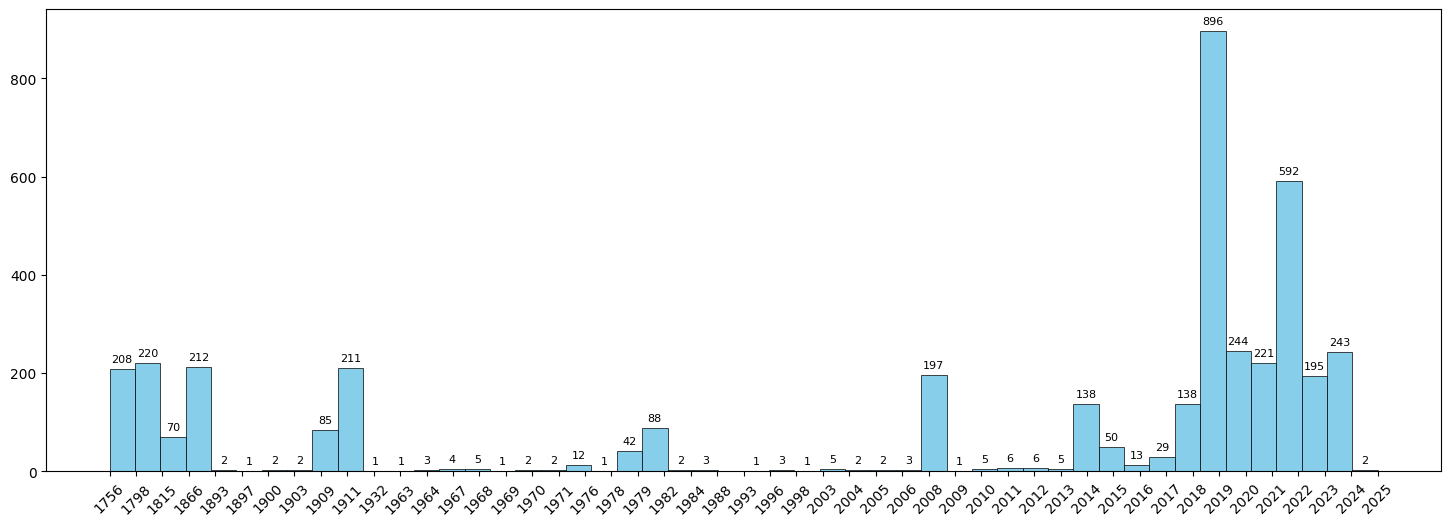

In [1200]:
ax = (
    facts_df["Год постройки"]
    .sort_values()
    .hist(
        bins=len(facts_df["Год постройки"].unique()),
        xrot=45,
        grid=False,
        figsize=(18, 6),
        color="skyblue",
        edgecolor="black",
        linewidth=0.5,
    )
)

for p in ax.patches:
    if p.get_height() > 0:  # Пишем только если в столбике есть данные
        ax.annotate(
            f"{int(p.get_height())}",  # Текст
            (p.get_x() + p.get_width() / 2.0, p.get_height()),  # Координаты (центр столбика)
            ha="center",
            va="center",  # Центровка
            xytext=(0, 7),  # Смещение текста вверх на 7 пунктов
            textcoords="offset points",
            fontsize=8,
        )

plt.show()

вероятно, наилучшим решением будет сгруппировать постройки по поколениям, так как данные распределены далеко не равномерно

In [1201]:
years = pd.to_numeric(facts_df["Год постройки"], errors="coerce")

conditions = [
    (years <= 1917),  # дореволюционные
    (years > 1917) & (years <= 1991),  # советские
    (years > 1991) & (years <= 2013),  # постсоветские
    (years > 2013),  # современные
]

choices = range(1, len(conditions) + 1)  # 0 - нет информации

facts_df["era_score"] = np.select(conditions, choices, default=0).astype(int)
facts_df = facts_df.drop(columns=["Год постройки"])

In [1202]:
facts_df["era_score"].value_counts()

era_score
4    2761
0    1979
1    1013
3     237
2     167
Name: count, dtype: int64

теперь посмотрим на тип дома

In [1203]:
facts_df["Тип дома"].value_counts()

Тип дома
Кирпичный              1599
Монолитный             1536
Монолитно-кирпичный     586
Панельный               283
Блочный                   3
Name: count, dtype: int64

во-первых, 3 блочных дома - это выброс, который стоит объединить с панельными домами

во-вторых, для типа дома не всегда понятно, как их ранжировать (кирпичный не всегда лучше деревянного), следовательно придется будет создавать dummy столбцы

в-третьих, надо понять, что делать с пропусками в данных. еще раз посмотрим на совокупность данных год постройки, тип дома и тип перекрытий

In [1204]:
facts_df[["Тип перекрытий"]].value_counts()

Тип перекрытий
Нет информации    3946
Железобетонные    1987
Смешанные          223
Деревянные           1
Name: count, dtype: int64

In [1205]:
facts_df["era_score"].value_counts()

era_score
4    2761
0    1979
1    1013
3     237
2     167
Name: count, dtype: int64

необходимо заполнить всевозможные пропуски, основываясь на логике и здравом смысле

In [1206]:
# Объединяем Блочный с Панельными, так как они технологически близки
facts_df["Тип дома"] = facts_df["Тип дома"].replace("Блочный", "Панельный")

# Заменим отсутствие информации на nan
facts_df["Тип перекрытий"] = facts_df["Тип перекрытий"].replace("Нет информации", np.nan)

будем заполнять тип дома, основываясь на его годе сдачи

In [1207]:
facts_df["Тип дома"].info()

<class 'pandas.Series'>
Index: 6157 entries, 0 to 6368
Series name: Тип дома
Non-Null Count  Dtype
--------------  -----
4007 non-null   str  
dtypes: str(1)
memory usage: 96.2 KB


In [1208]:
def fill_house_type(row):
    if pd.notna(row["Тип дома"]):
        return row["Тип дома"]

    if row["era_score"] == 4:
        return "Монолитно-кирпичный"  # Самый частый в новостройках
    if row["era_score"] == 1:
        return "Кирпичный"  # Старый фонд
    if row["era_score"] == 2:
        return "Панельный"  # Пик хрущевок
    return np.nan


facts_df["Тип дома"] = facts_df.apply(fill_house_type, axis=1)

In [1209]:
facts_df["Тип дома"].info()

<class 'pandas.Series'>
Index: 6157 entries, 0 to 6368
Series name: Тип дома
Non-Null Count  Dtype
--------------  -----
4714 non-null   str  
dtypes: str(1)
memory usage: 96.2 KB


In [1210]:
facts_df["Тип дома"].value_counts()

Тип дома
Кирпичный              1599
Монолитный             1536
Монолитно-кирпичный    1273
Панельный               306
Name: count, dtype: int64

аналогично заполним тип перекрытий

In [1211]:
facts_df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    1987
Смешанные          223
Деревянные           1
Name: count, dtype: int64

In [1212]:
def fill_floors(row):
    if pd.notna(row["Тип перекрытий"]):
        return row["Тип перекрытий"]

    # 1. Все современные дома (era 3 и 4) и советские панели — это Ж/Б
    if row["era_score"] >= 2:
        return "Железобетонные"

    # 2. В старом фонде (era 1), если инфо нет, смотрим на материал
    if row["era_score"] == 1:
        if row["Тип дома"] == "Кирпичный":
            return "Смешанные"  # В старом кирпиче чаще всего смешанный тип

    return np.nan


facts_df["Тип перекрытий"] = facts_df.apply(fill_floors, axis=1)

In [1213]:
facts_df["Тип перекрытий"].info()

<class 'pandas.Series'>
Index: 6157 entries, 0 to 6368
Series name: Тип перекрытий
Non-Null Count  Dtype
--------------  -----
4178 non-null   str  
dtypes: str(1)
memory usage: 96.2 KB


In [1214]:
facts_df["Тип перекрытий"].value_counts()

Тип перекрытий
Железобетонные    3954
Смешанные          223
Деревянные           1
Name: count, dtype: int64

объединим редкие классы в один

In [1215]:
facts_df["Тип перекрытий"] = facts_df["Тип перекрытий"].replace("Деревянные", "Смешанные")

удалим все записи, что не получилось заполнить данными

In [1216]:
facts_df = facts_df.dropna()

а также добавим dummy классы для типа дома для решения одной из вышеописанных проблем

In [1217]:
facts_df["Тип дома"].value_counts()

Тип дома
Кирпичный              1596
Монолитный             1534
Монолитно-кирпичный     940
Панельный                97
Name: count, dtype: int64

In [1218]:
houst_material = facts_df["Тип дома"].replace(
    {
        "Кирпичный": "brick",
        "Монолитный": "monolithic",
        "Монолитно-кирпичный": "monolithic_brick",
        "Панельный": "panel",
    }
)

house_dummies = pd.get_dummies(houst_material, dtype=int).add_prefix("house_type_").add_suffix("_flg")
facts_df = pd.concat([facts_df, house_dummies], axis=1)
facts_df = facts_df.drop(columns=["Тип дома"])
facts_df

,Тип перекрытий,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months,apartments_flg,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_level,freight_elevators_cnt,passenger_elevators_cnt,parking_level,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,era_score,house_type_brick_flg,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg
2,Смешанные,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3,Железобетонные,3500,0,1,34000,0.0,1,3,1,1,0,2,2,2,2,0,1,0,0,4,0,1,0,0
5,Железобетонные,0,1,1,44000,0.0,0,3,1,0,0,0,1,1,1,0,1,0,0,4,0,1,0,0
6,Железобетонные,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0
8,Железобетонные,2500,0,1,30000,0.0,1,12,0,1,0,2,1,1,1,0,1,1,0,4,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,Смешанные,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
6356,Железобетонные,5000,0,1,50000,0.5,1,12,0,1,0,3,0,2,2,0,0,0,0,4,0,0,1,0
6358,Железобетонные,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0
6361,Железобетонные,4000,0,1,65000,0.0,2,12,0,0,1,3,4,0,1,0,1,0,0,4,0,0,1,0


и переименуем оставшиеся непереименованные стобцы

In [1219]:
facts_df = facts_df.rename(columns={"Тип перекрытий": "floor_type"})

In [1220]:
facts_df["floor_type"].value_counts()

floor_type
Железобетонные    3943
Смешанные          224
Name: count, dtype: int64

только сейчас понял, что эту фичу можно превратить в бинарный флаг

In [1221]:
facts_df["floor_reinforced_concrete_flg"] = facts_df["floor_type"].str.contains("Желез").astype(int)
facts_df = facts_df.drop(columns=["floor_type"])

#### 2.4.6.3. Получившаяся витрина фич

In [1222]:
facts_df

,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months,apartments_flg,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_level,freight_elevators_cnt,passenger_elevators_cnt,parking_level,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,era_score,house_type_brick_flg,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg,floor_reinforced_concrete_flg
2,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,3500,0,1,34000,0.0,1,3,1,1,0,2,2,2,2,0,1,0,0,4,0,1,0,0,1
5,0,1,1,44000,0.0,0,3,1,0,0,0,1,1,1,0,1,0,0,4,0,1,0,0,1
6,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0,1
8,2500,0,1,30000,0.0,1,12,0,1,0,2,1,1,1,0,1,1,0,4,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
6356,5000,0,1,50000,0.5,1,12,0,1,0,3,0,2,2,0,0,0,0,4,0,0,1,0,1
6358,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0,1
6361,4000,0,1,65000,0.0,2,12,0,0,1,3,4,0,1,0,1,0,0,4,0,0,1,0,1


In [1223]:
facts_df.info()

<class 'pandas.DataFrame'>
Index: 4167 entries, 2 to 6368
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   utility_fixed_bill               4167 non-null   int64  
 1   utility_usage_bill_flg           4167 non-null   int64  
 2   utility_counters_extra_flg       4167 non-null   int64  
 3   deposit                          4167 non-null   int64  
 4   comission                        4167 non-null   float64
 5   prepayment_months_cnt            4167 non-null   int64  
 6   rent_term_months                 4167 non-null   int64  
 7   apartments_flg                   4167 non-null   int64  
 8   combined_bathrooms_cnt           4167 non-null   int64  
 9   separate_bathrooms_cnt           4167 non-null   int64  
 10  repair_level                     4167 non-null   int64  
 11  freight_elevators_cnt            4167 non-null   int64  
 12  passenger_elevators_cnt          416

In [1224]:
facts_df.describe()

,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months,apartments_flg,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_level,freight_elevators_cnt,passenger_elevators_cnt,parking_level,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,era_score,house_type_brick_flg,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg,floor_reinforced_concrete_flg
count,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.0,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000
mean,4711.255100,0.162707,0.922246,38192.824574,0.229717,0.868970,7.028078,0.411327,0.630430,0.185025,1.652988,0.732181,1.323254,0.989201,0.158147,0.251980,0.075594,0.0,3.136309,0.383009,0.368131,0.225582,0.023278,0.946244
std,2783.501136,0.369142,0.267816,23240.119884,0.342542,0.365474,4.475723,0.492133,0.486708,0.388982,0.950304,0.714219,1.071112,0.672931,0.365580,0.436957,0.264379,0.0,1.287200,0.486179,0.482355,0.418015,0.150804,0.225562
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4000.000000,0.000000,1.000000,20000.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5000.000000,0.000000,1.000000,35000.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6000.000000,0.000000,1.000000,48000.000000,0.500000,1.000000,12.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.0,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,25000.000000,1.000000,1.000000,430000.000000,1.000000,2.000000,12.000000,1.000000,2.000000,2.000000,3.000000,4.000000,4.000000,2.000000,2.000000,3.000000,1.000000,0.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.4.7. Оставшиеся флаги

In [1225]:
features_dummies = pd.get_dummies(df["features"].explode()).groupby(level=0).sum()
features_dummies

,Ванна,Душевая кабина,Интернет,Кондиционер,Мебель в комнатах,Мебель на кухне,Посудомоечная машина,Стиральная машина,Телевизор,Холодильник
0,0,1,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,1,0,1,1,1
3,1,1,1,0,1,1,1,1,1,1
4,0,1,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
6358,0,1,1,0,1,1,0,1,1,1
6359,0,1,1,0,1,1,0,1,1,1
6361,1,0,1,0,1,1,1,1,1,1
6365,1,0,1,1,1,0,0,0,1,1


In [1226]:
features_dummies.columns

Index(['Ванна', 'Душевая кабина', 'Интернет', 'Кондиционер',
       'Мебель в комнатах', 'Мебель на кухне', 'Посудомоечная машина',
       'Стиральная машина', 'Телевизор', 'Холодильник'],
      dtype='str')

In [1227]:
features_dummies = features_dummies.rename(
    columns={
        "Ванна": "has_bath_flg",
        "Душевая кабина": "has_shower_flg",
        "Интернет": "has_internet_flg",
        "Кондиционер": "has_ac_flg",
        "Мебель в комнатах": "has_room_furniture_flg",
        "Мебель на кухне": "has_kitchen_furniture_flg",
        "Посудомоечная машина": "has_dishwasher_flg",
        "Стиральная машина": "has_washer_flg",
        "Телевизор": "has_tv_flg",
        "Холодильник": "has_fridge_flg",
    }
)
features_dummies

,has_bath_flg,has_shower_flg,has_internet_flg,has_ac_flg,has_room_furniture_flg,has_kitchen_furniture_flg,has_dishwasher_flg,has_washer_flg,has_tv_flg,has_fridge_flg
0,0,1,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,1,0,1,1,1
3,1,1,1,0,1,1,1,1,1,1
4,0,1,1,0,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
6358,0,1,1,0,1,1,0,1,1,1
6359,0,1,1,0,1,1,0,1,1,1
6361,1,0,1,0,1,1,1,1,1,1
6365,1,0,1,1,1,0,0,0,1,1


### 2.4.8. Объединение в финальную витрину

In [1228]:
df = df.drop(columns=["facts", "features"])

In [1229]:
df

,price_per_month,metro_nearest_time,total_area,floor,city_district
0,55000,1,35.0,0.52,Московский
1,200000,19,200.0,0.80,Адмиралтейский
2,20500,4,15.0,0.25,Адмиралтейский
3,33990,11,22.0,0.73,Выборгский
4,27000,7,14.1,0.50,Центральный
...,...,...,...,...,...
6358,34700,14,25.0,0.65,Выборгский
6359,36700,13,25.0,0.50,Красногвардейский
6361,65000,11,30.5,0.44,Приморский
6365,114300,3,38.1,0.71,Центральный


In [1230]:
df["city_district"].value_counts()

city_district
Центральный          1118
Адмиралтейский        928
Выборгский            844
Московский            745
Приморский            685
Фрунзенский           575
Василеостровский      364
Красногвардейский     359
Невский               249
Калининский           228
Другой                 62
Name: count, dtype: int64

In [1231]:
district_dummies = (
    pd.get_dummies(
        df["city_district"].map(
            {
                "Центральный": "central",
                "Адмиралтейский": "admiralteysky",
                "Выборгский": "vyborgsky",
                "Московский": "moskovsky",
                "Приморский": "primorsky",
                "Фрунзенский": "frunzenskiy",
                "Василеостровский": "vasileostrovsky",
                "Красногвардейский": "krasnogvardeysky",
                "Невский": "nevsky",
                "Калининский": "kalininskiy",
                "Другой": "other",
            }
        ),
        dtype=int,
        drop_first=True,
    )
    .add_prefix("district_")
    .add_suffix("_flg")
)

df = pd.concat([df, district_dummies], axis=1)
df = df.drop(columns=["city_district"])
df

,price_per_month,metro_nearest_time,total_area,floor,district_central_flg,district_frunzenskiy_flg,district_kalininskiy_flg,district_krasnogvardeysky_flg,district_moskovsky_flg,district_nevsky_flg,district_other_flg,district_primorsky_flg,district_vasileostrovsky_flg,district_vyborgsky_flg
0,55000,1,35.0,0.52,0,0,0,0,1,0,0,0,0,0
1,200000,19,200.0,0.80,0,0,0,0,0,0,0,0,0,0
2,20500,4,15.0,0.25,0,0,0,0,0,0,0,0,0,0
3,33990,11,22.0,0.73,0,0,0,0,0,0,0,0,0,1
4,27000,7,14.1,0.50,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,34700,14,25.0,0.65,0,0,0,0,0,0,0,0,0,1
6359,36700,13,25.0,0.50,0,0,0,1,0,0,0,0,0,0
6361,65000,11,30.5,0.44,0,0,0,0,0,0,0,1,0,0
6365,114300,3,38.1,0.71,1,0,0,0,0,0,0,0,0,0


In [1232]:
df_final = df.join([facts_df, features_dummies], how="inner")
df_final

,price_per_month,metro_nearest_time,total_area,floor,district_central_flg,district_frunzenskiy_flg,district_kalininskiy_flg,district_krasnogvardeysky_flg,district_moskovsky_flg,district_nevsky_flg,district_other_flg,district_primorsky_flg,district_vasileostrovsky_flg,district_vyborgsky_flg,utility_fixed_bill,utility_usage_bill_flg,utility_counters_extra_flg,deposit,comission,prepayment_months_cnt,rent_term_months,apartments_flg,combined_bathrooms_cnt,separate_bathrooms_cnt,repair_level,freight_elevators_cnt,passenger_elevators_cnt,parking_level,balcony_cnt,loggia_cnt,has_garbage_chute_flg,has_concierge_flg,era_score,house_type_brick_flg,house_type_monolithic_flg,house_type_monolithic_brick_flg,house_type_panel_flg,floor_reinforced_concrete_flg,has_bath_flg,has_shower_flg,has_internet_flg,has_ac_flg,has_room_furniture_flg,has_kitchen_furniture_flg,has_dishwasher_flg,has_washer_flg,has_tv_flg,has_fridge_flg
2,20500,4,15.00,0.25,0,0,0,0,0,0,0,0,0,0,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,1,1,1
3,33990,11,22.00,0.73,0,0,0,0,0,0,0,0,0,1,3500,0,1,34000,0.0,1,3,1,1,0,2,2,2,2,0,1,0,0,4,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1
5,44000,3,24.00,0.56,0,1,0,0,0,0,0,0,0,0,0,1,1,44000,0.0,0,3,1,0,0,0,1,1,1,0,1,0,0,4,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1
6,34700,14,25.00,0.65,0,0,0,0,0,0,0,0,0,1,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0,1,0,1,1,0,1,1,0,1,1,1
8,30000,10,30.37,1.00,0,0,0,0,0,0,0,0,0,1,2500,0,1,30000,0.0,1,12,0,1,0,2,1,1,1,0,1,1,0,4,0,1,0,0,1,1,0,1,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,20500,4,15.00,0.25,0,0,0,0,0,0,0,0,0,0,5500,0,1,20500,1.0,1,12,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,1,1,1
6356,50000,7,41.00,0.62,0,0,0,0,0,0,0,1,0,0,5000,0,1,50000,0.5,1,12,0,1,0,3,0,2,2,0,0,0,0,4,0,0,1,0,1,0,0,1,0,1,1,1,1,1,1
6358,34700,14,25.00,0.65,0,0,0,0,0,0,0,0,0,1,4000,0,1,18000,0.0,1,3,0,1,0,2,1,4,1,0,0,0,0,4,0,1,0,0,1,0,1,1,0,1,1,0,1,1,1
6361,65000,11,30.50,0.44,0,0,0,0,0,0,0,1,0,0,4000,0,1,65000,0.0,2,12,0,0,1,3,4,0,1,0,1,0,0,4,0,0,1,0,1,1,0,1,0,1,1,1,1,1,1


In [1233]:
df_final.info()

<class 'pandas.DataFrame'>
Index: 4167 entries, 2 to 6368
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price_per_month                  4167 non-null   int64  
 1   metro_nearest_time               4167 non-null   int64  
 2   total_area                       4167 non-null   float64
 3   floor                            4167 non-null   float64
 4   district_central_flg             4167 non-null   int64  
 5   district_frunzenskiy_flg         4167 non-null   int64  
 6   district_kalininskiy_flg         4167 non-null   int64  
 7   district_krasnogvardeysky_flg    4167 non-null   int64  
 8   district_moskovsky_flg           4167 non-null   int64  
 9   district_nevsky_flg              4167 non-null   int64  
 10  district_other_flg               4167 non-null   int64  
 11  district_primorsky_flg           4167 non-null   int64  
 12  district_vasileostrovsky_flg     416

**💰 Финансовые показатели**

* `price_per_month`: Стоимость аренды в месяц.
* `deposit`: Сумма залога.
* `comission`: Комиссия агенту (доля).
* `prepayment_months_cnt`: Предоплата (за сколько месяцев вперед нужно заплатить).
* `utility_fixed_bill`: Фиксированная стоимость коммунальных услуг.
* `utility_usage_bill_flg`: Флаг, оплачиваются ли счета по ЖКХ полностью арендатором (то есть оплата ЖКХ не включена).
* `utility_counters_extra_flg`: Флаг, оплачиваются ли счетчики сверх арендной платы (то есть оплата ЖКХ не включена ИЛИ счетчики не включены в оплату ЖКХ).

---

**📍 Расположение и Районы**

* `metro_nearest_time`: Время в пути до ближайшего метро (в минутах).
* `district_<>_flg`: Серия бинарных признаков (One-Hot Encoding), указывающих на район города:
* *central* (Центральный), *frunzenskiy* (Фрунзенский), *kalininskiy* (Калининский), *krasnogvardeysky* (Красногвардейский), *moskovsky* (Московский), *nevsky* (Невский), *primorsky* (Приморский), *vasileostrovsky* (Василеостровский), *vyborgsky* (Выборгский), *other* (Прочие).



---

**🏢 Характеристики здания и квартиры**

* `total_area`: Общая площадь квартиры (кв. м).
* `floor`: Этаж, на котором расположена квартира в виде отношения (этаж квартиры к количеству этажей в здании).
* `rent_term_months`: Минимальный срок аренды в месяцах.
* `apartments_flg`: Является ли жилье апартаментами (юридический статус).
* `repair_level`: Уровень ремонта по шкале качества (0 — без ремонта/бабушкин, 1 — косметический, 2 — евроремонт, 3 — дизайнерский).
* `era_score`: Поколение постройки (1 — до 1917, 2 — советский период, 3 — постсоветский 1992-2013, 4 — современные дома с 2014 года).
* `house_type_<>_flg`: Тип постройки дома (кирпичный, монолитный, монолитно-кирпичный, панельный/блочный).
* `floor_reinforced_concrete_flg`: Тип перекрытий (1 — железобетонные, 0 — смешанные/деревянные/неизвестно в старом фонде).

---

**🛁 Удобства и Санузлы**

* `combined_bathrooms_cnt`: Количество совмещенных санузлов.
* `separate_bathrooms_cnt`: Количество раздельных санузлов.
* `has_bath_flg`: Наличие ванны.
* `has_shower_flg`: Наличие душевой кабины.
* `balcony_cnt` loggia_cnt**: Количество балконов и лоджий.

---

**🛠 Оснащение и Инфраструктура дома**

* `passenger_elevators_cnt`: Количество пассажирских лифтов.
* `freight_elevators_cnt`: Количество грузовых лифтов.
* `parking_level`: Уровень доступности парковки (0 — нет информации, 1 — наземная/открытая, 2 — подземная/многоуровневая).
* `has_garbage_chute_flg`: Наличие мусоропровода.
* `has_concierge_flg`: Наличие консьержа в подъезде.

---

**📺 Бытовая техника и Мебель**

* `has_internet_flg`: Наличие проведенного интернета.
* `has_ac_flg`: Наличие кондиционера.
* `has_room_furniture_flg`: Наличие мебели в комнатах.
* `has_kitchen_furniture_flg`: Наличие мебели на кухне.
* `has_dishwasher_flg`: Наличие посудомоечной машины.
* `has_washer_flg`: Наличие стиральной машины.
* `has_tv_flg`: Наличие телевизора.
* `has_fridge_flg`: Наличие холодильника.

In [1234]:
df_final.to_csv("data/cian_rentals_clean.csv", index=False, encoding="utf-8")